### Imports

In [0]:
import requests
import os
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType, ArrayType, StructType, StructField, IntegerType, StringType
from scipy.stats import ttest_ind, chi2_contingency
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis
import seaborn as sns

### Funções

In [0]:
def metricas_iqr(df, coluna):
    """
    Calcula as métricas baseadas no intervalo interquartil (IQR) para identificar outliers em uma coluna de um DataFrame Spark.

    Essa função calcula os quartis (Q1, mediana, Q3) para a coluna especificada no DataFrame,
    define os limites inferior e superior para identificação de outliers com base no IQR, filtra os valores que são
    considerados outliers e exibe as métricas calculadas, como os quartis, o IQR e o número de outliers encontrados.

    Parâmetros:
        df (DataFrame): DataFrame Spark contendo a coluna a ser analisada.
        coluna (str): O nome da coluna numérica no DataFrame para a qual as métricas IQR serão calculadas.

    Retorna:
        DataFrame: Um DataFrame Spark contendo apenas os registros que são considerados outliers.

    Exibe:
        - Valor de Q1 (1º quartil), mediana e Q3 (3º quartil).
        - Valor do IQR (intervalo interquartil).
        - Limites inferior e superior calculados para definir os outliers.
        - Número total de valores considerados outliers.
    """
    q1, median, q3 = df.approxQuantile(coluna, [0.25, 0.5, 0.75], 0.01)
    iqr = q3 - q1 

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df_outliers = df.filter((col(coluna) < lower_bound) | (col(coluna) > upper_bound))

    print(
        f"Q1: {q1}\n"
        f"Median: {median}\n"
        f"Q3: {q3}\n"
        f"IQR: {iqr}\n"
        f"Limites: inferior={lower_bound:.2f}, superior={upper_bound:.2f}\n"
        f"Número de outliers: {df_outliers.count()}"
    )
    
    return df_outliers

def teste_t(controle,target,coluna):
    """
    Realiza um teste T de Student para avaliar se há diferença significativa entre duas amostras em uma coluna específica.

    A função executa um teste T de Student (teste de hipótese) para comparar as médias de duas amostras (controle e target) 
    com base em uma coluna fornecida. O teste visa determinar se as diferenças entre os grupos são estatisticamente 
    significativas, assumindo variâncias desiguais (Welch's t-test).

    Parâmetros:
        controle (DataFrame): DataFrame Spark representando o grupo de controle.
        target (DataFrame): DataFrame Spark representando o grupo target.
        coluna (str): O nome da coluna que será comparada entre os grupos.
    """
    target_list = [row[coluna] for row in target.collect()]
    control_list = [row[coluna] for row in controle.collect()]
    
    stat, p_value = ttest_ind(control_list , target_list, equal_var=False)
    
    alpha = 0.05
    if p_value < alpha:
        print(p_value)
        print("Rejeita a hipótese nula: diferença significante.")
    else:
        print("Não rejeita a hipótese nula: sem diferença significante.")

### Reads

In [0]:
df_orders = spark.read.format("delta").load("/FileStore/iFood/dataset/orders_tratado/")
ab_test = spark.read.format("delta").load("/FileStore/iFood/dataset/ab_tratado")
df_consumer = spark.read.format("delta").load("/FileStore/iFood/dataset/consumer_tratado/")
restaurant = spark.read.format("delta").load("/FileStore/iFood/dataset/restaurant_tratado")

### Segmentação

Para o AB em questão, escolheu-se seguir com a segmentação RFM (Recência, Frequência e Valor).\
Foi usado como referência o dia 01/02/2019 (após a data do teste).

In [0]:
df_usuarios = (df_orders
  .select("customer_id","order_id","order_reference_timestamp","order_total_amount","is_target")
  .withColumn("order_reference_date", to_date(col("order_reference_timestamp")))
  .withColumn("days_difference", datediff(lit("2019-02-01"), col("order_reference_date")))
  .groupBy("customer_id","is_target")
  .agg(
    (sum("order_total_amount")).alias("valor"),
    (countDistinct("order_id")).alias("frequencia"),
    min("days_difference").alias("recencia")
  )    
)

Embora algumas colunas possuam outliers (como pode ser observado abaixo), optou-se apenas por identificá-los, tendo em vista que os dados de pedidos já foram anteriormente tratados. 

In [0]:
metricas_iqr(df = df_usuarios, coluna = "valor")

Q1: 39.5
Median: 72.9
Q3: 157.1
IQR: 117.6
Limites: inferior=-136.90, superior=333.50
Número de outliers: 77623
Out[5]: DataFrame[customer_id: string, is_target: string, valor: double, frequencia: bigint, recencia: int]

In [0]:
metricas_iqr(df = df_usuarios, coluna = "frequencia")

Q1: 1.0
Median: 2.0
Q3: 3.0
IQR: 2.0
Limites: inferior=-2.00, superior=6.00
Número de outliers: 83835
Out[6]: DataFrame[customer_id: string, is_target: string, valor: double, frequencia: bigint, recencia: int]

In [0]:
metricas_iqr(df = df_usuarios, coluna = "recencia")

Q1: 3.0
Median: 9.0
Q3: 18.0
IQR: 15.0
Limites: inferior=-19.50, superior=40.50
Número de outliers: 0
Out[7]: DataFrame[customer_id: string, is_target: string, valor: double, frequencia: bigint, recencia: int]

Embora a segmentação RFM pudesse ser realizada utilizando scores ou percentis, optou-se por empregar o algoritmo K-means para identificar os grupos de maneira mais dinâmica e baseada em similaridades.

In [0]:
pd_usuarios = df_usuarios.toPandas()

In [0]:
X = pd_usuarios[['recencia', 'frequencia', 'valor']]

In [0]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [0]:
wcss = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

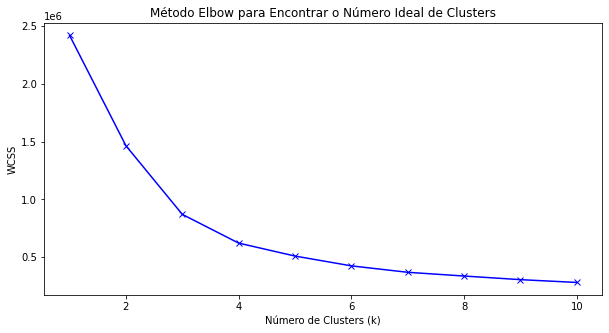

In [0]:
plt.figure(figsize=(10, 5))
plt.plot(k_values, wcss, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS')
plt.title('Método Elbow para Encontrar o Número Ideal de Clusters')
plt.show()

In [0]:
Pelo método Elbow, foi escolhidoseguir com 3 clusters.

In [0]:
kmeans = KMeans(n_clusters=3, random_state=42)
pd_usuarios['cluster'] = kmeans.fit_predict(X_scaled)

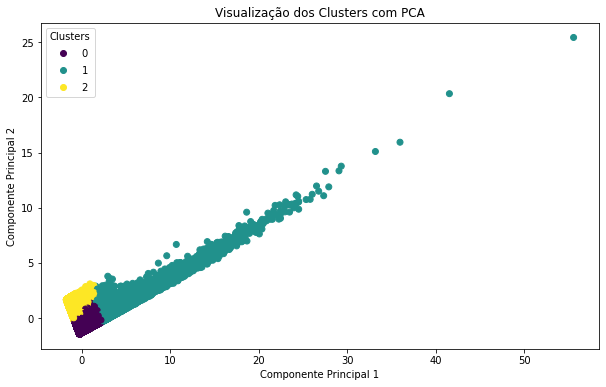

In [0]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Adicionar as componentes principais ao DataFrame
pd_usuarios['pca1'] = X_pca[:, 0]
pd_usuarios['pca2'] = X_pca[:, 1]

# Plotar os dados clusterizados
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pd_usuarios['pca1'], pd_usuarios['pca2'], c=pd_usuarios['cluster'], cmap='viridis')
plt.title('Visualização dos Clusters com PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [0]:
grouped_stats = pd_usuarios.groupby('cluster').agg(['mean', 'median', 'std', 'min', 'max'])
columns_to_include = ['recencia', 'frequencia', 'valor']
grouped_stats = grouped_stats[columns_to_include]

grouped_stats.head()

<command-489100378997941>:1: FutureWarning: ['customer_id', 'is_target'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  grouped_stats = pd_usuarios.groupby('cluster').agg(['mean', 'median', 'std', 'min', 'max'])


recencia 
 frequencia 
 valor 
 
 
 
 mean 
 median 
 std 
 min 
 max 
 mean 
 median 
 std 
 min 
 max 
 mean 
 median 
 std 
 min 
 max 
 
 
 cluster 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 5.866839 
 5.0 
 3.659177 
 1 
 19 
 2.833561 
 2.0 
 2.027847 
 1 
 13 
 127.419360 
 94.4 
 104.198219 
 1.00 
 858.30 
 
 
 1 
 3.008112 
 2.0 
 2.463063 
 1 
 28 
 13.499825 
 12.0 
 6.793230 
 1 
 157 
 721.031456 
 597.4 
 450.078355 
 69.50 
 11342.07 
 
 
 2 
 21.395071 
 21.0 
 4.997391 
 13 
 31 
 1.367006 
 1.0 
 0.747333 
 1 
 11 
 63.051877 
 48.0 
 51.738475 
 0.01 
 995.50

É possível classificar os grupos de clientes que compraram dentro do período do teste em:
- **Cluster 0: Clientes ocasionais** \
Grupo de clientes esporádicos moderados: compram de vez em quando, apresentam um valor de gasto médio e têm potencial para maior engajamento.
- **Cluster 1: Clientes VIP** \
Grupo de clientes engajados, com alta frequência e elevado valor de compra. 
- **Cluster 2: Clientes pouco ativos** \
Grupo de clientes com baixo engajamento: compraram há muito tempo, com baixa frequência e baixo ticket médio.

In [0]:
df_usuarios_cluster = spark.createDataFrame(pd_usuarios)

### Análise com base nas segmentações

In [0]:
df_orders_seg = (df_orders.alias("o")
    .join(
        df_usuarios_cluster.alias("cl"),
        col("o.customer_id") == col("cl.customer_id"),
        "left"
    )
    .select("o.customer_id","delivery_address_state","merchant_id","order_reference_timestamp","order_id","order_total_amount","o.is_target","items","cluster")
)

In [0]:
df_metricas_seg = (df_orders_seg
    .groupBy("customer_id","is_target","cluster")
    .agg(
        countDistinct("order_id").alias("tt_order"),
        sum("order_total_amount").alias("tt_gasto_usuario")
    )
)

In [0]:
metricas_seg = (df_metricas_seg.groupBy("is_target","cluster") 
    .agg( 
        count("customer_id").alias("total_users"), 
        (sum("tt_order")).alias("tt_orders"),
        (sum("tt_gasto_usuario")).alias("receita_total"),
        mean("tt_order").alias("freq_pdd_usuario"),
        (sum("tt_gasto_usuario")/sum("tt_order")).alias("ticket_medio")        
    ) 
)

In [0]:
metricas_seg.orderBy(col("is_target"),col("cluster")).display()

is_target,cluster,total_users,tt_orders,receita_total,freq_pdd_usuario,ticket_medio
control,0,197804,532692,2.3996528929998856E7,2.6930294635093324,45.047661556769874
control,1,21701,293138,1.5638141229999986E7,13.508041104096586,53.34736960066585
control,2,141009,184840,8548710.72000042,1.31083831528484,46.249246483447415
target,0,256878,755677,3.393876058999839E7,2.941773916022392,44.911728939743284
target,1,32538,439079,2.3469883899999995E7,13.494345073452578,53.45253109349341
target,2,156479,221828,1.0208466060000062E7,1.4176215338799456,46.01973628216484


A clusterização realizada com os usuários do teste resultou em três grupos distintos, que foram agrupados com base na semelhança de comportamentos. \
No entanto, é importante destacar que, idealmente, a segmentação dos usuários em clusters deveria ser realizada com dados de antes do início do teste A/B. \
Isso garante que os grupos estão estruturados com base em comportamentos semelhantes, permitindo uma melhor distribuição entre target e controle. Assim, mitigamos o risco de vieses introduzidos pelo próprio teste.
Realizar a segmentação antecipadamente ajuda a preservar a robustez do experimento, já que os grupos target e controle seriam comparáveis, respeitando as características de cada usuário. 

Utilizando como premissa que não há viés nessa segmentação e observando os indicadores de sucesso que foram estabelecidos, foi realizado o teste t.

In [0]:
# Cluster 0: Clientes ocasionais
freq_target_0_group = df_metricas_seg.filter((col("is_target") == "target") & (col("cluster") == 0)).select("tt_order")
freq_control_0_group = df_metricas_seg.filter((col("is_target") == "control") & (col("cluster") == 0)).select("tt_order")

teste_t(controle = freq_control_0_group, target = freq_target_0_group, coluna = "tt_order")

0.0
Rejeita a hipótese nula: diferença significante.


In [0]:
# Cluster 0: Clientes ocasionais
tkt_target_group = df_orders_seg.filter((col("is_target") == "target") & (col("cluster") == 0)).select("order_total_amount")
tkt_control_group = df_orders_seg.filter((col("is_target") == "control") & (col("cluster") == 0)).select("order_total_amount")

teste_t(controle = tkt_control_group, target = tkt_target_group, coluna = "order_total_amount")

0.011058399470623143
Rejeita a hipótese nula: diferença significante.


In [0]:
#Cluster 1: Clientes VIP
freq_target_1_group = df_metricas_seg.filter((col("is_target") == "target") & (col("cluster") == 1)).select("tt_order")
freq_control_1_group = df_metricas_seg.filter((col("is_target") == "control") & (col("cluster") == 1)).select("tt_order")

teste_t(controle = freq_control_1_group, target = freq_target_1_group, coluna = "tt_order")

Não rejeita a hipótese nula: sem diferença significante.


In [0]:
#Cluster 1: Clientes VIP
tkt_target_1_group = df_orders_seg.filter((col("is_target") == "target") & (col("cluster") == 1)).select("order_total_amount")
tkt_control_1_group = df_orders_seg.filter((col("is_target") == "control") & (col("cluster") == 1)).select("order_total_amount")

teste_t(controle = tkt_control_1_group, target = tkt_target_1_group, coluna = "order_total_amount")

Não rejeita a hipótese nula: sem diferença significante.


In [0]:
#Cluster 2: Clientes pouco ativos
freq_target_2_group = df_metricas_seg.filter((col("is_target") == "target") & (col("cluster") == 2)).select("tt_order")
freq_control_2_group = df_metricas_seg.filter((col("is_target") == "control") & (col("cluster") == 2)).select("tt_order")

teste_t(controle = freq_control_2_group, target = freq_target_2_group, coluna = "tt_order")

0.0
Rejeita a hipótese nula: diferença significante.


In [0]:
#Cluster 2: Clientes pouco ativos
tkt_target_2_group = df_orders_seg.filter((col("is_target") == "target") & (col("cluster") == 2)).select("order_total_amount")
tkt_control_2_group = df_orders_seg.filter((col("is_target") == "control") & (col("cluster") == 2)).select("order_total_amount")

teste_t(controle = tkt_control_2_group, target = tkt_target_2_group, coluna = "order_total_amount")

0.02000263286338154
Rejeita a hipótese nula: diferença significante.


A partir desses dados, é possível observar que a presença de cupons para clientes VIP (cluster 1) não influencia no comportamento do grupo. Tanto a frequência de pedidos quanto o ticket médio são iguais. \
Já para clientes ocasionais e os pouco ativos (cluster 0 e 2), a presença do cupom impactou tanto a frequência de pedidos quanto o ticket médio. Usuários target desses grupos apresentaram aumento na frequência de pedidos, no entanto o ticket médio reduziu.  
Para os 3 grupos o ROI permaneceu negativo.
([Material com cálculos](https://docs.google.com/spreadsheets/d/1amdnvCE4CmwSudfLNPjKMudqqbi7yvjdZat6gsmD4jc/edit?usp=sharing))

### Próximos passos

**- Implementar uma segmentação utilizando dados históricos** \
Redefinir os segmentos analisados com base em dados que preexistem à campanha, como frequência de pedidos, ticket médio, categorias favoritas, comportamento de consumo anterior ou engajamento histórico.

**- Realizar Testes AB Focados em Segmentos com Maior Potencial** \
Depois de identificar clusters mais promissores pelos filtros históricos, realizar novos experimentos AB com esses segmentos.

**- Realizar Testes para entender a melhor configuração de cupom** \
Após identificar quais são os segmentos com maior potencial, entender valores de cupons para identificar o ponto ideal em que o usuário fica satisfeito e ocorre incremento de pedidos, enquanto o impacto em métricas-chave do negócio são minimizados ou até otimizado. 